In [20]:
### If You do not have one of these packages, you can simply run: !pip install <package>

# You may also find this video helpful for permanent installations (basically installs folder to your drive)
# >> https://www.youtube.com/watch?v=ErwLcnvhW4A&t=473s

# You may also find this paper helpful for some intro information / description of optimizer algorithms
# >> https://arxiv.org/pdf/1803.08823

import torch
from fastai.tabular.all import *
from tqdm import tqdm

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

In [21]:
import sympy as sym
from scipy.integrate import quad
from scipy.integrate import cumulative_trapezoid

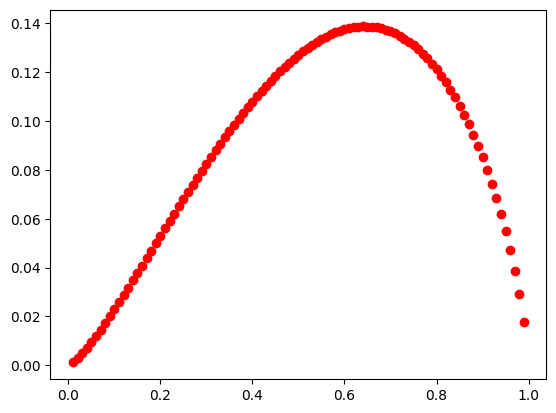

In [22]:
### Toy Model Parton Distribution Function

x = torch.arange(1,100).float()/100.

def h(x, params):

  N,a,b = params

  return N*x**a*(1-x)**b

def show(preds, ax=None):
    if ax is None:
        ax = plt.subplots()[1]
    # ax.scatter(time, signal)
    ax.scatter(x, to_np(preds), color="red")
    plt.show()

sig_params = torch.abs(torch.randn(3)).requires_grad_()
# sig_params
signal = h(x, sig_params)
show(signal)

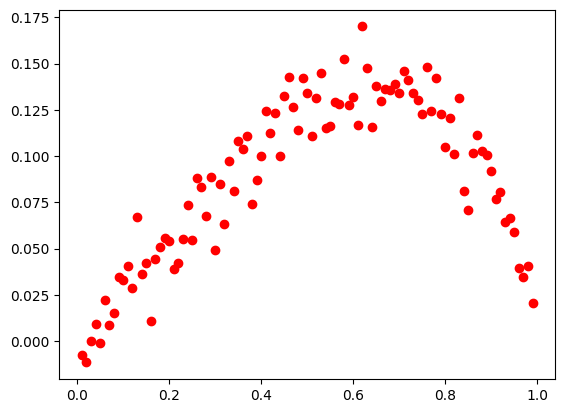

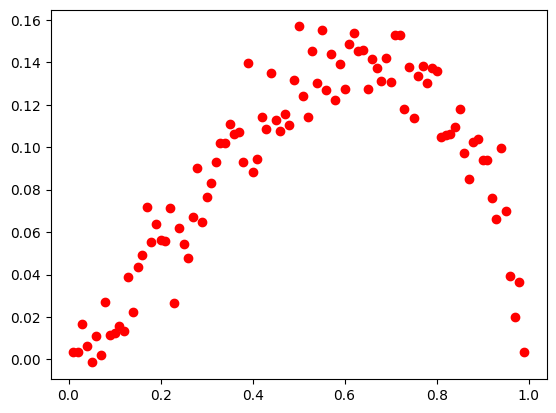

In [23]:
### Generate Data w/ Noise

# If we perform a fit with different pieces of noisey data to generate an uncertainty band \n
# This is known as the replica method (or monte carlo method) for generating uncertainty

N_train = 100
max_sig = max(signal.data)
min_sig = min(signal.data)
noise_amp = 0.1*(max_sig - min_sig)
X_train = []

for i in range(N_train):
  noise = torch.randn_like(signal)*noise_amp
  sample = signal + noise
  X_train.append(sample)

show(X_train[0])
show(X_train[30])

In [24]:
### Loss Functions

# Loss per sample
def mserr(preds, targets):
    return ((preds - targets) ** 2).mean()

# Loss per round of training (So takes in entire trainging set)
def batch_loss(preds):

  temp_loss = 0
  for i in range(N_train):

    temp_loss += mserr(preds, X_train[i])

  temp_loss /= N_train #average loss

  return temp_loss

In [25]:
##### DNN Regression

In [26]:
##### Define Model for Collinear Modulation

### NN = NN(x, q_type); q_type is quark type (modulate pdf for each quark type to prouce g_1T)
### For moderate x, restrict to just valence (up and down)

### Need to normalize to N >> But N is a parameter? I guess just choose N = 1

### NN Definition

class MLPcondensed(nn.Module):
    '''
    Multi-layer perceptron for non-linear regression.
    '''
    def __init__(self, nInput, nHidden, nOutput):
        super().__init__()
        self.layers = nn.Sequential(
            # Specify layers, followed by activation for that layer
            # What if you want different activations for different nodes?
            # When would that ^ be desireable?
            nn.Linear(nInput, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nHidden),
            #nn.Sigmoid(),
            #nn.LeakyReLU(),
            #nn.ReLU(),
            nn.Tanh(),
            #nn.Softplus(),
            nn.Linear(nHidden, nOutput)
        )

    def forward(self, x):
        return(self.layers(x))

    # def forward(self, zL, zh, hadron, lambda_bar):
    #     return(self.layers(zL, zh, hadron, lambda_bar))

### 2 input x, q_type
mlpCondensed = MLPcondensed(1,3,1)
DNN_model_1 = mlpCondensed

In [27]:
### Loss Function

def mse_f(preds, targets):

    # preds = model(x)

    return ((preds - targets) ** 2).mean()

def batch_loss(preds):

    loss = 0

    for n in range(N_train):

        targets = X_train[n]
        loss += ((preds - targets) ** 2).mean()

    return loss / N_train

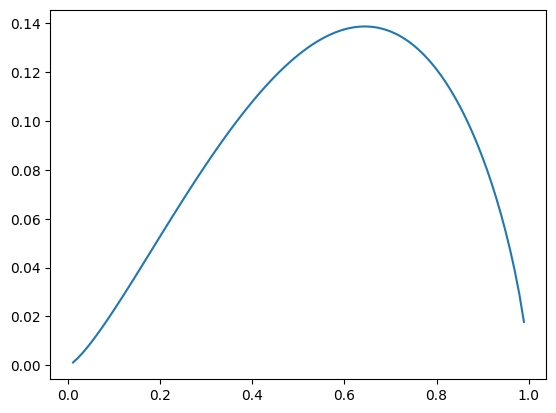

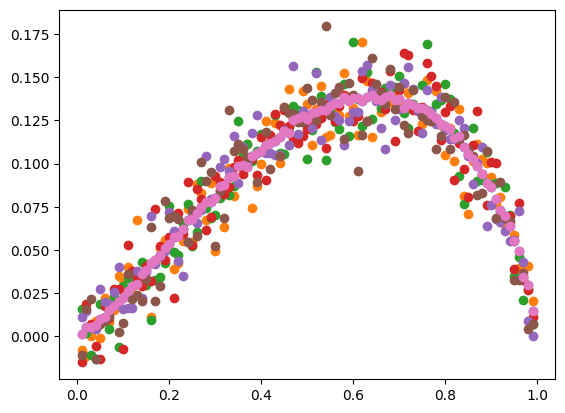

In [28]:
### Plot Central Values

# Just to see how the average data (the true function, if you like) compares across the entire set

plt.figure(0)
plt.plot(x.data, h(x, sig_params).data)


### Plot scattered central values

plt.figure(1)

avg_rep = torch.zeros(len(x))

for n in range(N_train):

    avg_rep += X_train[n]

avg_rep /= N_train

plt.scatter(x.data, avg_rep.data)
for i in range(5): plt.scatter(x.data, X_train[i].data)

plt.scatter(x.data, avg_rep.data)

In [29]:
# This is necessary for DNN_model_1 to serve as an input to our model

x_input = torch.reshape(x, (len(x), 1))

# Ex:
DNN_model_1(x_input).squeeze()

tensor([0.4783, 0.4783, 0.4783, 0.4783, 0.4783, 0.4784, 0.4784, 0.4784, 0.4784,
        0.4784, 0.4784, 0.4784, 0.4784, 0.4784, 0.4784, 0.4785, 0.4785, 0.4785,
        0.4785, 0.4785, 0.4785, 0.4785, 0.4785, 0.4786, 0.4786, 0.4786, 0.4786,
        0.4786, 0.4786, 0.4786, 0.4787, 0.4787, 0.4787, 0.4787, 0.4787, 0.4787,
        0.4788, 0.4788, 0.4788, 0.4788, 0.4788, 0.4789, 0.4789, 0.4789, 0.4789,
        0.4789, 0.4790, 0.4790, 0.4790, 0.4790, 0.4790, 0.4791, 0.4791, 0.4791,
        0.4791, 0.4791, 0.4792, 0.4792, 0.4792, 0.4792, 0.4793, 0.4793, 0.4793,
        0.4793, 0.4794, 0.4794, 0.4794, 0.4794, 0.4794, 0.4795, 0.4795, 0.4795,
        0.4795, 0.4796, 0.4796, 0.4796, 0.4796, 0.4797, 0.4797, 0.4797, 0.4797,
        0.4798, 0.4798, 0.4798, 0.4798, 0.4799, 0.4799, 0.4799, 0.4800, 0.4800,
        0.4800, 0.4800, 0.4801, 0.4801, 0.4801, 0.4801, 0.4802, 0.4802, 0.4802],
       grad_fn=<SqueezeBackward0>)

In [30]:
### Organize data into batches
xObs = x
yObs = X_train[0]

for i in range(1, len(X_train)):

    xObs = torch.cat((xObs, x))
    yObs = torch.cat((yObs, X_train[i]))

In [31]:
### Organize Training Data

### They want to use Dataloaders in batches of 25 training points
### Apparently networks learn better this way

class nonLinearRegressionData(Dataset): #Dataset comes with some nice methods
    '''
    Custom 'Dataset' object for our regression data.
    Must implement these functions: __init__, __len__, and __getitem__.
    '''

    def __init__(self, xObs, yObs):

        # Reshape I think because need them to be matrices for network input
        self.xObs = torch.reshape(xObs, (len(xObs), 1))
        self.yObs = torch.reshape(yObs, (len(yObs), 1))

    def __len__(self):
        return(len(self.xObs))

    def __getitem__(self, idx):
        return(xObs[idx], yObs[idx])

# instantiate Dataset object for current training data
d = nonLinearRegressionData(xObs, yObs)

print(d)

#Here want batch size = full input, deterministic (no randomizing order even)
train_dataloader = DataLoader(d, batch_size=len(x_input) , shuffle=False)

In [32]:
### Train
from tqdm import tqdm

# Define the loss function and optimizer
mlpCondensed = MLPcondensed(1,10,1)
DNN_model = mlpCondensed
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(DNN_model.parameters(), lr=1e-2)
nTrainSteps = 30
#nTrainSteps = 60
initial_params = []

def training(a):
  torch.manual_seed(a)
  mlpCondensed = MLPcondensed(1,10,1)
  DNN_model_test = mlpCondensed
  # Got rid of momentum to turn this into regular gradient descent
  # Batch gradient descent (aka regular) since now SDG just takes all the data instead of getting different batches 
  # (In SDG each epoch it focuses on different batches)
  optimizer_2 = torch.optim.SGD(DNN_model_test.parameters(), lr=1e-2)
  initial_params.append(list(DNN_model_test.parameters()))
  # Track loss over epochs
  track_loss = np.zeros(nTrainSteps)
  #saved_data = 0 #for whatever training data was used
  # Run the training loop
  for epoch in tqdm(range(0, nTrainSteps)):
    # Iterate over the DataLoader for training data
    for i, data in enumerate(train_dataloader, 0):

      # Get inputs
      inputs, targets = data
      # Zero the gradients
      optimizer_2.zero_grad()
      # Perform forward pass (make sure to supply the input in the right way)
      outputs = DNN_model_test(torch.reshape(inputs, (len(inputs), 1))).squeeze()
      #saved_data = inputs
      # Compute loss
      loss = loss_function(outputs, targets)

      # Perform backward pass
      loss.backward(retain_graph = True)

      # Perform optimization
      optimizer_2.step()

      track_loss[epoch] = loss.item()

  #Changing so we're getting output from testing the model
  tested_output = DNN_model_test(x_input).squeeze().data
  #return track_loss, tested_output, a, list(DNN_model_test.parameters())# outputs, saved_data
  return track_loss, tested_output, a

# Process is complete.
#print('Training process has finished.')

In [33]:
import threading
#import concurrent.futures

100%|██████████| 30/30 [00:06<00:00,  4.71it/s]


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


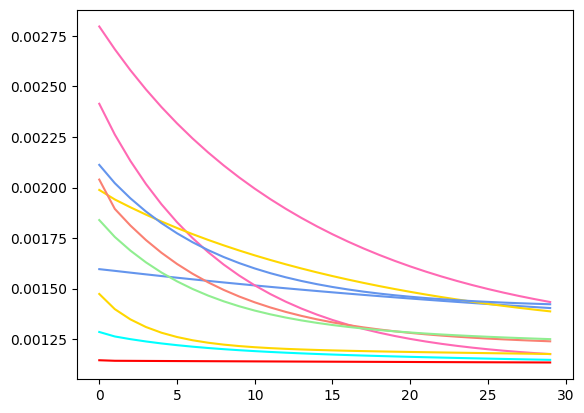

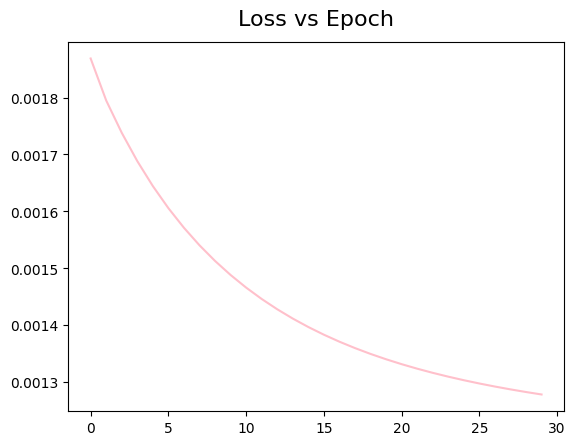

In [34]:
done_losses = {} #dictionary
gotten_results = {}
outputs = []
saved_params = []
numIters = 10
from concurrent.futures import ProcessPoolExecutor as Executor
saved_thread_nums = []
with Executor() as executor:
  for i in range(0,numIters):
    thread_num = "t" + str(i)
    thread_num = executor.submit(training, i)
    saved_thread_nums.append(thread_num)
  
  for i in range(0,numIters):
    #results_of_iteration, outputs, test, initial_params_one = saved_thread_nums[i].result()
    results_of_iteration, outputs, test = saved_thread_nums[i].result()
    #initial_params.append(inital_params_one)
    colors = ["cornflowerblue", "hotpink", "gold", "salmon", "lightgreen", "aqua", "red", "lightpink"]
    plt.plot(np.arange(nTrainSteps), results_of_iteration, color = colors[i%7])
    print(saved_params)
    #print(test)
    #results_of_iteration, outputs, data_trained = training() #gets current array
    #results_of_iteration, outputs, one_sample, data_trained = training() #gets current array
    #print(results_of_iteration)
    for j in range(0,nTrainSteps):
      if j in done_losses:
        done_losses[j] += results_of_iteration[j]
      else:
        done_losses[j] = results_of_iteration[j]
    #gotten_results[i] = DNN_model(x_input).squeeze().data
    gotten_results[i] = outputs

average_losses = [0]*nTrainSteps
for i in range(0,nTrainSteps):
  average_losses[i] = done_losses[i]/numIters

avg_results = [0]*len(gotten_results[0])
for i in range(0,numIters):
  for j in range(0,len(gotten_results[i])):
      avg_results[j] += gotten_results[i][j]
  #print(avg_results)
for i in range(0,len(avg_results)):
  avg_results[i] /= numIters

# print("average losses ", average_losses)
plt.figure(0)
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses, color = "pink")
#plt.plot(np.arange(nTrainSteps), results_of_iteration, label = "Last iteration", color = "blue")


In [35]:
#for i in range(0,len(initial_params)):
 #   print(initial_params[i])
#print(len(initial_params))
#print(initial_params[1])
#print("space")
#print(initial_params[2])

test
99
<class 'list'>
[0.0018689651391468943, 0.0017950449255295098, 0.0017381610930897295, 0.001688282156828791, 0.0016443365369923414, 0.001605445414315909, 0.0015708915540017187, 0.0015400830656290055, 0.0015125275822356343, 0.0014878109097480774, 0.0014655831968411804, 0.0014455451746471226, 0.0014274409622885287, 0.0014110488933511077, 0.001396176393609494, 0.0013826562557369471, 0.0013703415752388537, 0.001359103643335402, 0.0013488290249370038, 0.0013394175912253559, 0.0013307804241776467, 0.0013228396303020418, 0.00131552490638569, 0.0013087746221572161, 0.0013025336782447993, 0.0012967523536644876, 0.0012913870508782566, 0.0012863984797149897, 0.0012817513663321734, 0.0012774142785929143]
<class 'torch.Tensor'>
<class 'torch.Tensor'>


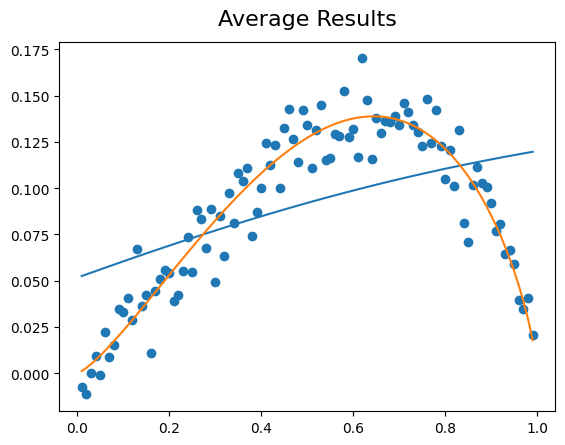

In [36]:
### I find it useful to plot how the loss evolves during training
print("test")
print(len(avg_results))
print(type(avg_results))
#print(len(data_trained))
#print(type(data_trained.detach().numpy()))
print(average_losses)
print(type(x.data))
print(type(h(x, sig_params).data))
plt.title("Average Results", fontsize = 16, pad = 12)
plt.plot(x.data, avg_results, label = 'Average Fit')
#plt.plot(data_trained, avg_results, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)
# This can tell you if we plateau rapidly, etc

#plt.figure(0)
#plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
#plt.plot(np.arange(nTrainSteps), track_loss)

In [37]:
### Plot model results, true signal, and noisey data point

'''avg_tensor = torch.tensor(one_sample, dtype=torch.float32)
sorted_tensor = avg_tensor.sort()[0]
#print(type(x.data))
plt.title("One Sample", fontsize = 16, pad = 12)
#FOR LOOP TO .detach().numpy() each value in avg_results???
new_list = [0]*len(avg_results)
for i in range(0,len(new_list)):
  new_list[i] = avg_results[i].detach()
print("test")
print(new_list)
dict_vals = {}
for i in range(0,len(avg_tensor)):
  dict_vals[data_trained[i]] = avg_tensor[i]
sorted_dict_keys = sorted(dict_vals.keys())
sorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}
print(sorted_dict)
new_tensor_list = [0]*len(dict_vals)
new_values_list = [0]*len(dict_vals)
i = 0
for key in sorted_dict:
  new_values_list[i] = key
  new_tensor_list[i] = sorted_dict[key]
  i += 1
print("hi")
print(new_tensor_list)
plt.plot(new_values_list, new_tensor_list, label = 'Average Fit')
plt.plot(x.data, h(x, sig_params).data, label = 'True PDF')
plt.scatter(x.data, X_train[0].data)'''

'avg_tensor = torch.tensor(one_sample, dtype=torch.float32)\nsorted_tensor = avg_tensor.sort()[0]\n#print(type(x.data))\nplt.title("One Sample", fontsize = 16, pad = 12)\n#FOR LOOP TO .detach().numpy() each value in avg_results???\nnew_list = [0]*len(avg_results)\nfor i in range(0,len(new_list)):\n  new_list[i] = avg_results[i].detach()\nprint("test")\nprint(new_list)\ndict_vals = {}\nfor i in range(0,len(avg_tensor)):\n  dict_vals[data_trained[i]] = avg_tensor[i]\nsorted_dict_keys = sorted(dict_vals.keys())\nsorted_dict = {key: dict_vals[key] for key in sorted_dict_keys}\nprint(sorted_dict)\nnew_tensor_list = [0]*len(dict_vals)\nnew_values_list = [0]*len(dict_vals)\ni = 0\nfor key in sorted_dict:\n  new_values_list[i] = key\n  new_tensor_list[i] = sorted_dict[key]\n  i += 1\nprint("hi")\nprint(new_tensor_list)\nplt.plot(new_values_list, new_tensor_list, label = \'Average Fit\')\nplt.plot(x.data, h(x, sig_params).data, label = \'True PDF\')\nplt.scatter(x.data, X_train[0].data)'

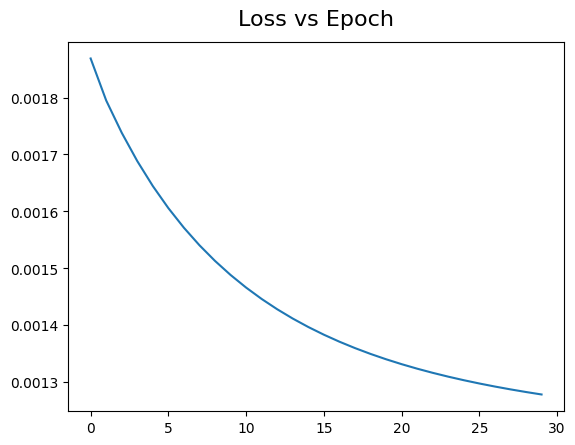

In [38]:
plt.title("Loss vs Epoch", fontsize = 16, pad = 12)
plt.plot(np.arange(nTrainSteps), average_losses)